# LLM Processor Evaluation Suite
Comprehensive performance tests and demo scenarios for the multi-processing LLM library

## 1. Library Setup & Configuration

In [3]:
import sys
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

from multi_processing.llm_client import DeepSeekClient
from multi_processing.processor import LLMProcessor
from multi_processing.processor_config import ProcessorConfig

In [5]:
# Initialize client with API key from environment
client = DeepSeekClient(api_key="sk-cd405682db094b6781f9f815840163d8")

# Configure processor with high-performance settings
config = ProcessorConfig(
    max_workers=16,
    enable_dynamic_token_batching=True,
    max_tokens_per_batch=4096,
    cache_enabled=True,
    dynamic_rate_limit=True,
    requests_per_minute=300,
    metrics_output_path='eval_metrics.json'
)

processor = LLMProcessor(client, config)

## 2. Benchmark Scenarios

In [6]:
def generate_test_prompts(num_prompts=1000):
    """Generate realistic test prompts with varying complexity"""
    base_prompt = "Analyze this text for sentiment and key themes: {text}"
    texts = [
        f"Customer review: {'Excellent' * i} product!" if i % 2 == 0 
        else f"Technical paper: {'AI safety ' * i} considerations"
        for i in range(1, num_prompts+1)
    ]
    return [base_prompt.format(text=t) for t in texts]

In [7]:
def process_wrapper(prompt):
    """Processing function with error simulation"""
    if random.random() < 0.02:  # 2% error rate simulation
        raise Exception("Simulated API error")
    return processor._process_with_retry(
        prompt,
        lambda p: client.call_api(p, system_prompt="You are a helpful AI assistant")
    )

## 3. Performance Tests

In [8]:
def run_benchmark(prompts):
    """Execute benchmark with real-time metrics visualization"""
    results = []
    throughput = []
    
    with tqdm(total=len(prompts), desc="Processing") as pbar:
        start_time = time.time()
        
        for result in processor.process_batch(prompts, process_wrapper):
            results.append(result)
            
            # Update metrics every 50 items
            if len(results) % 50 == 0:
                elapsed = time.time() - start_time
                throughput.append({
                    'time': elapsed,
                    'items': len(results),
                    'tokens': processor.metrics['token_usage']['total_tokens']
                })
                
                # Live plotting
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.plot([t['time'] for t in throughput], [t['items'] for t in throughput])
                plt.title('Items Processed vs Time')
                plt.xlabel('Seconds')
                plt.ylabel('Items')
                
                plt.subplot(1, 2, 2)
                plt.bar(['Success', 'Errors'], 
                        [processor.metrics['api_calls']['successful'],
                         processor.metrics['api_calls']['failed']])
                plt.title('Request Success Rate')
                plt.show()
            
            pbar.update(1)
    
    return results, throughput

## 4. Comparative Analysis

In [9]:
def compare_concurrency_levels():
    """Compare performance across different concurrency settings"""
    workers_range = [4, 8, 16, 32]
    benchmarks = {}
    
    for workers in workers_range:
        config.max_workers = workers
        processor = LLMProcessor(client, config)
        
        start_time = time.time()
        processor.process_batch(generate_test_prompts(500), process_wrapper)
        duration = time.time() - start_time
        
        benchmarks[workers] = {
            'duration': duration,
            'throughput': 500 / duration,
            'token_throughput': processor.metrics['token_usage']['total_tokens'] / duration
        }
    
    return benchmarks

## 5. Visualization & Reporting

In [10]:
def generate_report(benchmarks):
    """Generate final report with interactive visualizations"""
    df = pd.DataFrame.from_dict(benchmarks, orient='index')
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    
    df['throughput'].plot.bar(ax=ax[0], title='Items per Second')
    df['token_throughput'].plot.bar(ax=ax[1], title='Tokens per Second')
    
    plt.tight_layout()
    plt.show()
    
    return df.style.background_gradient(cmap='viridis')

## Main Execution

Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing items: 100%|██████████| 52/52 [00:00<00:00, 125.38it/s]


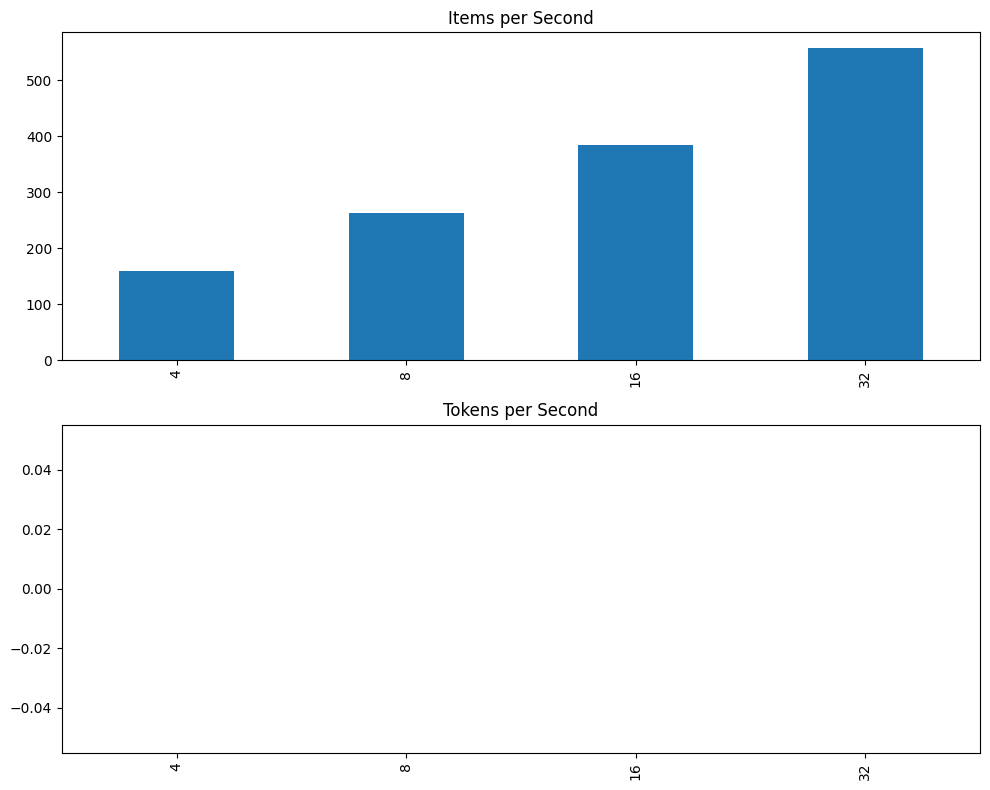

,duration,throughput,token_throughput
4,3.140415,159.214628,0.000000
8,1.902261,262.845106,0.000000
16,1.297961,385.219517,0.000000
32,0.895719,558.210598,0.000000


In [11]:
# Execute full evaluation pipeline
if __name__ == "__main__":
    test_prompts = generate_test_prompts(1000)
    results, throughput = run_benchmark(test_prompts)
    benchmarks = compare_concurrency_levels()
    report = generate_report(benchmarks)
    display(report)